## IBM Data Science Capstone Project

### Clustering Neighborhoods in Toronto Using Crime and Location Data

In [141]:
import json
import re

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Data Acquisition and Cleaning

Get the data from the Wikipedia website

In [142]:
page = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
page.status_code

200

In [143]:
soup = BeautifulSoup(page.content, 'html.parser')

table = soup.find('table', attrs={'class':'wikitable sortable'})
table_body = table.find('tbody')

data = []
rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [elem.text.strip() for elem in cols]
    data.append([elem for elem in cols if elem])
    
data[:5]

[[],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village']]

Load the raw data into a pandas data frame

In [144]:
columns = ['PostalCode', 'Borough', 'Neighborhood']
df_raw = pd.DataFrame(data[1:], columns=columns)
df_raw.head(10)

PostalCode           Borough                                 Neighborhood
0        M1A      Not assigned                                 Not assigned
1        M2A      Not assigned                                 Not assigned
2        M3A        North York                                    Parkwoods
3        M4A        North York                             Victoria Village
4        M5A  Downtown Toronto                    Regent Park, Harbourfront
5        M6A        North York             Lawrence Manor, Lawrence Heights
6        M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government
7        M8A      Not assigned                                 Not assigned
8        M9A         Etobicoke      Islington Avenue, Humber Valley Village
9        M1B       Scarborough                               Malvern, Rouge

Clean the raw data and check for 'Not assigned' values

In [145]:
df = df_raw[df_raw['Borough'] != 'Not assigned'].reset_index(drop=True)
(df['Neighborhood'] == 'Not assigned').value_counts()

False    103
Name: Neighborhood, dtype: int64

Load the raw geospatial coordinates data into a pandas data frame

In [146]:
df_coordinates = pd.read_csv('data/geospatial_coordinates.csv')
df_coordinates.head(5)

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [147]:
df_coordinates.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
df_coordinates.head(2)

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497

Join the neighborhoods and the geospatial coordinates dataframe

In [148]:
df_combined = pd.merge(df, df_coordinates, on='PostalCode')
df_combined.head(5)

PostalCode           Borough                                 Neighborhood  \
0        M3A        North York                                    Parkwoods   
1        M4A        North York                             Victoria Village   
2        M5A  Downtown Toronto                    Regent Park, Harbourfront   
3        M6A        North York             Lawrence Manor, Lawrence Heights   
4        M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

    Latitude  Longitude  
0  43.753259 -79.329656  
1  43.725882 -79.315572  
2  43.654260 -79.360636  
3  43.718518 -79.464763  
4  43.662301 -79.389494

In [149]:
df_combined.shape

(103, 5)

Define Foursquare credentials and version

In [150]:
CLIENT_ID = 'YQJDXEJW40NOM2OZB43BCVVMXD5Y4MD031OPJ3GNOLX5D4MI'             # Foursquare ID
CLIENT_SECRET = 'WIT2NLNHTFRXKBFH01ZORX4ZYS231F2SZZWU4JMZDNDHQCJF'         # Foursquare Secret
VERSION = '20180605'            # Foursquare API version
LIMIT = 100

Get the Foursquare location data for each neighborhood

In [151]:
def get_nearby_venues(names, latitudes, longitudes, radius=500):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            )
            for v in results
            ])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Neighborhood', 
        'Neighborhood Latitude', 
        'Neighborhood Longitude', 
        'Venue', 
        'Venue Latitude', 
        'Venue Longitude', 
        'Venue Category',
        ]
    
    return nearby_venues

In [153]:
toronto_venues = get_nearby_venues(names=df_combined['Neighborhood'],
                                   latitudes=df_combined['Latitude'],
                                   longitudes=df_combined['Longitude'])

Find out how many unique categories can be curated from all the returned venues

In [154]:
n_venues = len(toronto_venues['Venue Category'].unique())
print(f'There are {n_venues} unique categories.')

There are 276 unique categories.


Prepare the data to analyze each neighborhood

In [155]:
# One hot encoding
toronto_dummies = pd.get_dummies(toronto_venues['Venue Category'], prefix='_', prefix_sep='')

# Add neighborhood column back to data frame
toronto_onehot = pd.concat([toronto_venues[['Neighborhood']], toronto_dummies], axis=1)

toronto_onehot.head()

Neighborhood  _Accessories Store  _Afghan Restaurant  _Airport  \
0         Parkwoods                   0                   0         0   
1         Parkwoods                   0                   0         0   
2         Parkwoods                   0                   0         0   
3  Victoria Village                   0                   0         0   
4  Victoria Village                   0                   0         0   

   _Airport Food Court  _Airport Gate  _Airport Lounge  _Airport Service  \
0                    0              0                0                 0   
1                    0              0                0                 0   
2                    0              0                0                 0   
3                    0              0                0                 0   
4                    0              0                0                 0   

   _Airport Terminal  _American Restaurant  ...  \
0                  0                     0  ...   
1                  0                     0  ...   
2                  0                     0  ...   
3                  0                     0  ...   
4                  0                     0  ...   

   _Vegetarian / Vegan Restaurant  _Video Game Store  _Video Store  \
0                               0                  0             0   
1                               0                  0             0   
2                               0                  0             0   
3                               0                  0             0   
4                               0                  0             0   

   _Vietnamese Restaurant  _Warehouse Store  _Wine Bar  _Wine Shop  \
0                       0                 0          0           0   
1                       0                 0          0           0   
2                       0                 0          0           0   
3                       0                 0          0           0   
4                       0                 0          0           0   

   _Wings Joint  _Women's Store  _Yoga Studio  
0             0               0             0  
1             0               0             0  
2             0               0             0  
3             0               0             0  
4             0               0             0  

[5 rows x 277 columns]

In [156]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

toronto_grouped.shape

(97, 277)

Create a new data frame and display the top ten venues for each neighborhood

In [157]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [158]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append(f'{ind+1}{indicators[ind]} Most Common Venue')
    except:
        columns.append(f'{ind+1}th Most Common Venue')

# Create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :],
                                                                          num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                                        Agincourt               _Lounge   
1                           Alderwood, Long Branch          _Pizza Place   
2  Bathurst Manor, Wilson Heights, Downsview North                 _Bank   
3                                  Bayview Village                 _Café   
4                Bedford Park, Lawrence Manor East       _Sandwich Place   

  2nd Most Common Venue       3rd Most Common Venue 4th Most Common Venue  \
0       _Breakfast Spot  _Latin American Restaurant         _Skating Rink   
1          _Coffee Shop                        _Gym             _Pharmacy   
2          _Coffee Shop                       _Park          _Pizza Place   
3                 _Bank        _Japanese Restaurant   _Chinese Restaurant   
4   _Italian Restaurant                _Coffee Shop           _Restaurant   

  5th Most Common Venue       6th Most Common Venue 7th Most Common Venue  \
0       _Clothing Store                  _Drugstore       _Discount Store   
1       _Sandwich Place               _Skating Rink         _Dance Studio   
2        _Deli / Bodega  _Middle Eastern Restaurant           _Restaurant   
3   _Dim Sum Restaurant             _Discount Store  _Distribution Center   
4     _Sushi Restaurant           _Greek Restaurant      _Thai Restaurant   

      8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0      _Distribution Center              _Dog Run      _Doner Restaurant  
1                      _Pub                 _Pool                 _Diner  
2           _Ice Cream Shop    _Mobile Phone Shop   _Fried Chicken Joint  
3                  _Dog Run     _Doner Restaurant            _Donut Shop  
4  _Comfort Food Restaurant            _Juice Bar               _Butcher

Load the raw crime data set into a data frame

In [159]:
df_crimes_raw = pd.read_csv('data/neighbourhood_crime_rates.csv')
df_crimes_raw.head(5)

OBJECTID            Neighbourhood  Hood_ID  Population  Assault_2014  \
0         1           Yonge-St.Clair       97       12528            20   
1         2  York University Heights       27       27593           271   
2         3         Lansing-Westgate       38       16164            44   
3         4       Yorkdale-Glen Park       31       14804           106   
4         5      Stonegate-Queensway       16       25051            88   

   Assault_2015  Assault_2016  Assault_2017  Assault_2018  Assault_2019  ...  \
0            29            39            27            34            37  ...   
1           296           361           344           357           370  ...   
2            80            68            85            75            72  ...   
3           136           174           161           175           209  ...   
4            71            76            95            87            82  ...   

   TheftOver_2015  TheftOver_2016  TheftOver_2017  TheftOver_2018  \
0               5               8               0               3   
1              46              37              39              38   
2               5               5              11               6   
3              14              26              23              20   
4               8               4               6               7   

   TheftOver_2019  TheftOver_AVG  TheftOver_CHG  TheftOver_Rate_2019  \
0               6            4.3           1.00                 47.9   
1              28           36.3          -0.26                101.5   
2              11            7.0           0.83                 68.1   
3              29           22.5           0.45                195.9   
4               4            6.0          -0.43                 16.0   

    Shape__Area  Shape__Length  
0  1.161315e+06    5873.270582  
1  1.324666e+07   18504.777326  
2  5.346186e+06   11112.109625  
3  6.038326e+06   10079.426920  
4  7.946202e+06   11853.189878  

[5 rows x 60 columns]

Clean the data set and keep only relevant columns

In [160]:
crimes_columns = ['Neighbourhood', 'Population', 'Assault_AVG', 'AutoTheft_AVG', 'BreakandEnter_AVG',
                 'Homicide_AVG', 'Robbery_AVG', 'TheftOver_AVG']
df_crimes = df_crimes_raw[crimes_columns].sort_values(by=['Neighbourhood'])
df_crimes.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
df_crimes['Neighborhood'] = df_crimes['Neighborhood'].str.replace('-', ', ')
df_crimes.head()

Neighborhood  Population  Assault_AVG  AutoTheft_AVG  \
79                Agincourt North       29113         74.8           29.7   
80  Agincourt South, Malvern West       23757        117.8           36.7   
86                      Alderwood       12054         36.3           16.2   
56                          Annex       30526        246.3           22.0   
84             Banbury, Don Mills       27695         80.5           21.8   

    BreakandEnter_AVG  Homicide_AVG  Robbery_AVG  TheftOver_AVG  
79               53.5           0.2         30.2            4.7  
80               79.8           0.2         27.3           13.3  
86               24.7           0.2          6.8            6.8  
56              147.5           0.5         40.8           29.5  
84               73.2           0.0         15.0           10.3

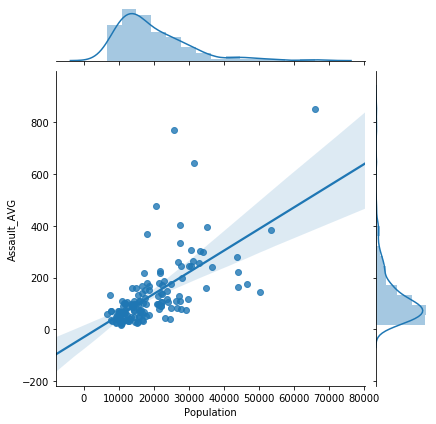

In [161]:
plot_pop_assault = sns.jointplot('Population', 'Assault_AVG', data=df_crimes, kind='reg')

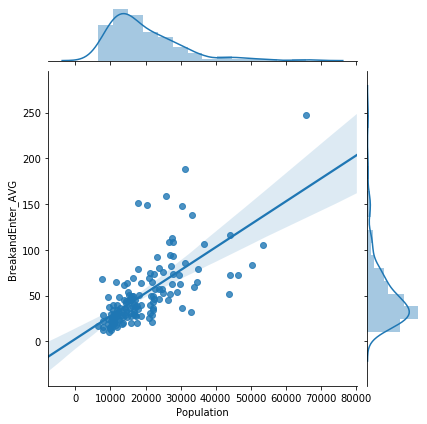

In [162]:
plot_pop_break = sns.jointplot('Population', 'BreakandEnter_AVG', data=df_crimes, kind='reg')

Adjust data in crime data frame to neighborhoods data frame

In [163]:
crimes_adjusted_raw = np.zeros((toronto_grouped.shape[0], 7))

for row_crime, hood_crime in enumerate(df_crimes['Neighborhood'].values):
    for row_loc, hood_loc in enumerate(toronto_grouped['Neighborhood'].values):
        
        # Search for common neighborhood entries
        if (set(hood_crime.split(',')) & set(hood_loc.split(',')) or
            set(re.split(', | ', hood_crime)) & set(hood_loc.split(',')) or
            set(hood_crime.split(',')) & set(re.split(', | ', hood_loc))):
            
            crimes_adjusted_raw[row_loc, :] = crimes_adjusted_raw[row_loc, :] + df_crimes.values[row_crime, 1:]
            
# Create new data frame            
df_crimes_adjusted = pd.DataFrame(crimes_adjusted_raw, columns=crimes_columns[1:])

# Add neighborhood column back to data frame
df_crimes_adjusted = pd.concat([toronto_grouped[['Neighborhood']], df_crimes_adjusted], axis=1)
df_crimes_adjusted.head()

Neighborhood  Population  Assault_AVG  \
0                                        Agincourt     52870.0        192.6   
1                           Alderwood, Long Branch     12054.0         36.3   
2  Bathurst Manor, Wilson Heights, Downsview North     50925.0        446.3   
3                                  Bayview Village     21396.0         76.7   
4                Bedford Park, Lawrence Manor East     23236.0         44.0   

   AutoTheft_AVG  BreakandEnter_AVG  Homicide_AVG  Robbery_AVG  TheftOver_AVG  
0           66.4              133.3           0.4         57.5           18.0  
1           16.2               24.7           0.2          6.8            6.8  
2          134.5              110.1           1.3         74.0           18.5  
3           20.5               40.2           0.2          8.8            8.3  
4           45.8               92.5           0.0         13.0           11.3

Remove null values and drop duplicates (where data has been assigned to more than one neighborhood) and scale crimes to crime per person (population)

In [164]:
df_crimes_adjusted = df_crimes_adjusted[df_crimes_adjusted['Population'] != 0.0].drop_duplicates(['Population'])
scaled = df_crimes_adjusted.iloc[:, 2:].div(df_crimes_adjusted['Population'], axis=0)
df_crimes_adjusted = pd.concat([df_crimes_adjusted[['Neighborhood', 'Population']], scaled], axis=1)
df_crimes_adjusted.head()

Neighborhood  Population  Assault_AVG  \
0                                        Agincourt     52870.0     0.003643   
1                           Alderwood, Long Branch     12054.0     0.003011   
2  Bathurst Manor, Wilson Heights, Downsview North     50925.0     0.008764   
3                                  Bayview Village     21396.0     0.003585   
4                Bedford Park, Lawrence Manor East     23236.0     0.001894   

   AutoTheft_AVG  BreakandEnter_AVG  Homicide_AVG  Robbery_AVG  TheftOver_AVG  
0       0.001256           0.002521      0.000008     0.001088       0.000340  
1       0.001344           0.002049      0.000017     0.000564       0.000564  
2       0.002641           0.002162      0.000026     0.001453       0.000363  
3       0.000958           0.001879      0.000009     0.000411       0.000388  
4       0.001971           0.003981      0.000000     0.000559       0.000486

Adjust location and geospatial coordinates data frames

In [165]:
df_location_adjusted = toronto_grouped.iloc[df_crimes_adjusted.index].reset_index(drop=True)
df_venues_sorted_adjusted = neighborhoods_venues_sorted.iloc[df_crimes_adjusted.index].reset_index(drop=True)
df_geo_adjusted = df_combined.iloc[df_crimes_adjusted.index].reset_index(drop=True)
df_crimes_adjusted.reset_index(drop=True, inplace=True)

### Clustering of Neighborhoods

Run different algorithms to cluster the neighborhood (using the location data) into 5 clusters

In [166]:
# Set number of clusters
n_clusters = 5

# Standardize the data
#scaler_loc = StandardScaler()
#location_data_scaled = scaler_loc.fit_transform(df_location_adjusted.values[:, 1:])

# Run k-means clustering
#model_loc = KMeans(n_clusters=kclusters, random_state=42)
#model_loc.fit(location_data_scaled)

# Run spectral clustering (graph-based)
model_loc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                               assign_labels='kmeans', random_state=42)

model_loc.fit(df_location_adjusted.values[:, 1:])

# Check cluster labels generated for each row in the dataframe
model_loc.labels_

array([4, 3, 1, 1, 1, 4, 1, 0, 1, 1, 2, 4, 3, 2, 4, 4, 4, 3, 4, 1, 1, 3,
       1, 4, 0, 2, 0, 3, 4, 4, 3, 2, 1, 2, 4, 4, 0, 2, 0, 1, 0, 1, 1, 1,
       1, 1, 4, 3, 2, 4, 1], dtype=int32)

Run different algorithms to cluster the neighborhood (using the crime data) into 5 clusters

In [167]:
# Standardize the data
#scaler_crimes = StandardScaler()
#crimes_data_scaled = scaler_crimes.fit_transform(df_crimes_adjusted.values[:, 2:])

# Run k-means clustering
#model_crimes = KMeans(n_clusters=n_clusters, random_state=42)
#model_crimes.fit(crimes_data_scaled)

# Run spectral clustering (graph-based)
model_crimes = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                                  assign_labels='kmeans', random_state=42)

model_crimes.fit(df_crimes_adjusted.values[:, 2:])

# Check cluster labels generated for each row in the dataframe
model_crimes.labels_

array([3, 3, 4, 3, 3, 4, 0, 1, 2, 2, 0, 2, 3, 0, 4, 1, 3, 4, 4, 0, 0, 1,
       3, 2, 1, 3, 4, 4, 0, 4, 1, 1, 0, 1, 3, 1, 3, 0, 1, 2, 3, 2, 1, 2,
       1, 4, 1, 3, 0, 3, 4], dtype=int32)

### Visualization of Results

Create a new data frame that includes the cluster as well as the top ten venues for each neighborhood

In [168]:
# Add clustering labels
df_venues_sorted_adjusted.insert(0, 'Cluster Labels', model_loc.labels_)

# Add latitude / longitude for each neighborhood
df_venues_sorted_merged = pd.concat([df_venues_sorted_adjusted,
                                     df_geo_adjusted[['Latitude', 'Longitude']]], axis=1)

df_venues_sorted_merged.head(10)

Cluster Labels                                       Neighborhood  \
0               4                                          Agincourt   
1               3                             Alderwood, Long Branch   
2               1    Bathurst Manor, Wilson Heights, Downsview North   
3               1                                    Bayview Village   
4               1                  Bedford Park, Lawrence Manor East   
5               4  CN Tower, King and Spadina, Railway Lands, Har...   
6               1                               Church and Wellesley   
7               0            Clarks Corners, Tam O'Shanter, Sullivan   
8               1    Cliffside, Cliffcrest, Scarborough Village West   
9               1  Dorset Park, Wexford Heights, Scarborough Town...   

  1st Most Common Venue 2nd Most Common Venue       3rd Most Common Venue  \
0               _Lounge       _Breakfast Spot  _Latin American Restaurant   
1          _Pizza Place          _Coffee Shop                        _Gym   
2                 _Bank          _Coffee Shop                       _Park   
3                 _Café                 _Bank        _Japanese Restaurant   
4       _Sandwich Place   _Italian Restaurant                _Coffee Shop   
5     _Airport Terminal       _Airport Lounge            _Airport Service   
6          _Coffee Shop     _Sushi Restaurant        _Japanese Restaurant   
7          _Pizza Place  _Rental Car Location          _Convenience Store   
8  _American Restaurant                _Motel               _Dessert Shop   
9    _Indian Restaurant            _Pet Store      _Vietnamese Restaurant   

  4th Most Common Venue 5th Most Common Venue       6th Most Common Venue  \
0         _Skating Rink       _Clothing Store                  _Drugstore   
1             _Pharmacy       _Sandwich Place               _Skating Rink   
2          _Pizza Place        _Deli / Bodega  _Middle Eastern Restaurant   
3   _Chinese Restaurant   _Dim Sum Restaurant             _Discount Store   
4           _Restaurant     _Sushi Restaurant           _Greek Restaurant   
5      _Harbor / Marina                  _Bar                      _Plane   
6              _Gay Bar           _Restaurant                _Yoga Studio   
7   _Italian Restaurant  _Fried Chicken Joint            _Thai Restaurant   
8                _Diner       _Discount Store        _Distribution Center   
9   _Chinese Restaurant              _Dog Run               _Dessert Shop   

  7th Most Common Venue     8th Most Common Venue  9th Most Common Venue  \
0       _Discount Store      _Distribution Center               _Dog Run   
1         _Dance Studio                      _Pub                  _Pool   
2           _Restaurant           _Ice Cream Shop     _Mobile Phone Shop   
3  _Distribution Center                  _Dog Run      _Doner Restaurant   
4      _Thai Restaurant  _Comfort Food Restaurant             _Juice Bar   
5     _Sculpture Garden                 _Boutique         _Boat or Ferry   
6                  _Pub                     _Café           _Men's Store   
7   _Chinese Restaurant              _Gas Station  _Fast Food Restaurant   
8              _Dog Run         _Doner Restaurant            _Donut Shop   
9   _Dim Sum Restaurant                    _Diner        _Discount Store   

  10th Most Common Venue   Latitude  Longitude  
0      _Doner Restaurant  43.753259 -79.329656  
1                 _Diner  43.725882 -79.315572  
2   _Fried Chicken Joint  43.654260 -79.360636  
3            _Donut Shop  43.718518 -79.464763  
4               _Butcher  43.662301 -79.389494  
5          _Airport Gate  43.657162 -79.378937  
6                 _Hotel  43.651494 -79.375418  
7          _Noodle House  43.693781 -79.428191  
8           _Yoga Studio  43.643515 -79.577201  
9   _Distribution Center  43.709060 -79.363452

Visualize the resulting clusters

In [170]:
toronto_geo = 'data/neighborhood_crime_rates.geojson'
latitude = 43.6534817
longitude = -79.3839347

# Define the threshold scale
threshold_scale = np.linspace(df_crimes_raw['Population'].min(),
                              df_crimes_raw['Population'].max(),
                              6, dtype=int).tolist()
threshold_scale[-1] = threshold_scale[-1] + 1

# Create map
toronto_map = folium.Map([latitude, longitude], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Create chloropleth map with population per neighborhood
toronto_map.choropleth(
    geo_data=toronto_geo,
    data=df_crimes_raw,
    columns=['Neighbourhood', 'Population'],
    key_on='feature.properties.Neighbourhood',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population',
    reset=True
    )

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_venues_sorted_merged['Latitude'],
                                  df_venues_sorted_merged['Longitude'],
                                  df_venues_sorted_merged['Neighborhood'],
                                  df_venues_sorted_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7
        ).add_to(toronto_map)
    
toronto_map

Create a new data frame that includes the cluster as well as the crimes for each neighborhood

In [171]:
# Add clustering labels
df_crimes_adjusted.insert(0, 'Cluster Labels', model_crimes.labels_)

# Add latitude / longitude for each neighborhood
df_crimes_merged = pd.concat([df_crimes_adjusted,
                              df_geo_adjusted[['Latitude', 'Longitude']]], axis=1)

df_crimes_merged.head(10)

Cluster Labels                                       Neighborhood  \
0               3                                          Agincourt   
1               3                             Alderwood, Long Branch   
2               4    Bathurst Manor, Wilson Heights, Downsview North   
3               3                                    Bayview Village   
4               3                  Bedford Park, Lawrence Manor East   
5               4  CN Tower, King and Spadina, Railway Lands, Har...   
6               0                               Church and Wellesley   
7               1            Clarks Corners, Tam O'Shanter, Sullivan   
8               2    Cliffside, Cliffcrest, Scarborough Village West   
9               2  Dorset Park, Wexford Heights, Scarborough Town...   

   Population  Assault_AVG  AutoTheft_AVG  BreakandEnter_AVG  Homicide_AVG  \
0     52870.0     0.003643       0.001256           0.002521      0.000008   
1     12054.0     0.003011       0.001344           0.002049      0.000017   
2     50925.0     0.008764       0.002641           0.002162      0.000026   
3     21396.0     0.003585       0.000958           0.001879      0.000009   
4     23236.0     0.001894       0.001971           0.003981      0.000000   
5     31180.0     0.008457       0.000792           0.002742      0.000026   
6     31340.0     0.020511       0.001206           0.006015      0.000064   
7     27446.0     0.003997       0.000838           0.002284      0.000026   
8     38226.0     0.007364       0.000889           0.003197      0.000021   
9     25003.0     0.007059       0.002088           0.003032      0.000020   

   Robbery_AVG  TheftOver_AVG   Latitude  Longitude  
0     0.001088       0.000340  43.753259 -79.329656  
1     0.000564       0.000564  43.725882 -79.315572  
2     0.001453       0.000363  43.654260 -79.360636  
3     0.000411       0.000388  43.718518 -79.464763  
4     0.000559       0.000486  43.662301 -79.389494  
5     0.000657       0.000529  43.657162 -79.378937  
6     0.004330       0.001078  43.651494 -79.375418  
7     0.001009       0.000200  43.693781 -79.428191  
8     0.001141       0.000259  43.643515 -79.577201  
9     0.001512       0.000368  43.709060 -79.363452

Visualize the resulting clusters

In [172]:
# Create map
toronto_map = folium.Map([latitude, longitude], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Create chloropleth map with population per neighborhood
toronto_map.choropleth(
    geo_data=toronto_geo,
    data=df_crimes_raw,
    columns=['Neighbourhood', 'Population'],
    key_on='feature.properties.Neighbourhood',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population',
    reset=True
    )

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_crimes_merged['Latitude'],
                                  df_crimes_merged['Longitude'],
                                  df_crimes_merged['Neighborhood'],
                                  df_crimes_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7
        ).add_to(toronto_map)
    
toronto_map

## Delete credentials